# Hyperparameter Optimization with Hyperopt
Here, we try out the hyperopt package and try to use a simple scikitlearn classifier and tune its hyperparameter using the hyperopt package.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load the data
df_train = pd.read_table('data/labeledTrainData.tsv', sep='\t')
df_test = pd.read_table('data/testData.tsv', sep='\t')

# Add a column for the score (out of 10)
df_train['score'] = df_train['id'].map(lambda x: int(x.split('_')[1]))
df_test['score'] = df_test['id'].map(lambda x: int(x.split('_')[1]))

# Add a column for the class, 1 for positive, 0 for negative
df_train['class'] = df_train['score'].map(lambda x: int(x > 5))
df_test['class'] = df_test['score'].map(lambda x: int(x > 5))

# Sort the df_test by class (it will need to be sorted later)
df_test = df_test.sort_values('class', ascending=False)

In [3]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words('english')

# Function for removing stopwords from a string
def removeStopwords(s):
    return ' '.join([word for word in s.split() if word not in cachedStopWords])

# Function for cleaning the reviews
def cleanText(s):
    s = s.str.lower()                         # Convert to lowercase
    s = s.str.replace(r'<.*?>', ' ')          # Remove HTML characters
    s = s.str.replace('\'', '')               # Remove single quotes ' 
    s = s.str.replace('-', '')                # Remove dashes -
    s = s.str.replace(r'[^a-zA-Z]', ' ')      # Remove non alpha characters
    s = s.map(lambda s: ' '.join(s.split()))  # Remove extra whitespae
    s = s.str.strip()                         # Remove whitespace at start and end
    s = s.apply(lambda x: removeStopwords(x)) # Remove stopwords
    return s
 
# Clean the reviews
df_train['review'] = cleanText(df_train['review'])
df_test['review'] = cleanText(df_test['review'])

In [4]:
# Separate into training and test data
X_train = df_train['review']
y_train = df_train['class']
X_test = df_test['review']
y_test = df_test['class']

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection.univariate_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline

# The model
vectorizer = TfidfVectorizer(strip_accents='unicode')
kbest = SelectPercentile(chi2)
clf = SGDClassifier(loss='modified_huber', penalty='elasticnet')

pipe = Pipeline([('vec', vectorizer),
                 ('kbest', kbest),
                 ('clf', clf)])

In [8]:
from sklearn import metrics
pipe.fit(X_train, y_train)
metrics.roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])

0.95247242559999989

In [9]:
from hyperopt import hp

# Parameter search space
space = {}
# One of (1,1), (1,2), or (1,3)
space['vec__ngram_range'] = hp.choice('vec__ngram_range', [(1,1), (1,2), (1,3)])
# Uniform between 0.7 and 1
space['vec__max_df'] = hp.uniform('vec__max_df', 0.7, 1.0)
# One of True or False
space['vec__sublinear_tf'] = hp.choice('vec__sublinear_tf', [True, False])
# Random number between 50 and 100
space['kbest__percentile'] = hp.uniform('kbest__percentile', 50, 100)
# Random number between 0 and 1
space['clf__l1_ratio'] = hp.uniform('clf__l1_ratio', 0.0, 1.0)
# Log-uniform between 1e-9 and 1e-4
space['clf__alpha'] = hp.loguniform('clf__alpha', -9*np.log(10), -4*np.log(10))
# Random integer in 20:5:80
space['clf__n_iter'] = 20 + 5*hp.randint('clf__n_iter', 12)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

def objective(params):
    pipe.set_params(**params)
    #shuffle = KFold(n_splits=2, shuffle=True)
    #score = cross_val_score(pipe, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)
    pipe.fit(X_train, y_train)
    score = metrics.roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
    return 1-score

In [32]:
from hyperopt import fmin, tpe, Trials

# The Trials object will store details of each iteration
#trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=100,
            trials=warmTrials)

In [12]:
trials.best_trial

{'book_time': datetime.datetime(2018, 6, 30, 11, 42, 34, 95000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'clf__alpha': [7],
   'clf__l1_ratio': [7],
   'clf__n_iter': [7],
   'kbest__percentile': [7],
   'vec__max_df': [7],
   'vec__ngram_range': [7],
   'vec__sublinear_tf': [7]},
  'tid': 7,
  'vals': {'clf__alpha': [1.0649254309338435e-05],
   'clf__l1_ratio': [0.6943053412718708],
   'clf__n_iter': [8],
   'kbest__percentile': [58.42041520828515],
   'vec__max_df': [0.7880997691199646],
   'vec__ngram_range': [1],
   'vec__sublinear_tf': [0]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 6, 30, 11, 43, 11, 111000),
 'result': {'loss': 0.05005612800000003, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 7,
 'version': 0}

In [13]:
warmTrials = trials

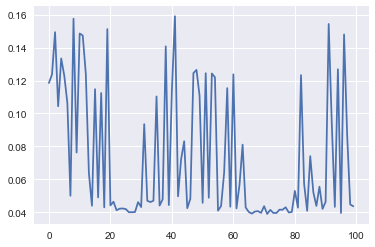

In [33]:
plt.plot(range(len(warmTrials.losses())), warmTrials.losses())

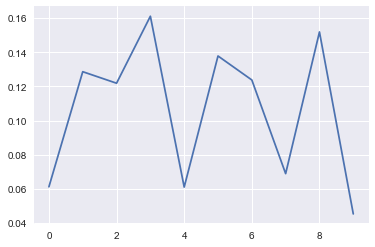

In [34]:
plt.plot(range(len(trials.losses())), trials.losses())

In [27]:
trials.best_trial

{'book_time': datetime.datetime(2018, 6, 30, 12, 12, 52, 511000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'clf__alpha': [9],
   'clf__l1_ratio': [9],
   'clf__n_iter': [9],
   'kbest__percentile': [9],
   'vec__max_df': [9],
   'vec__ngram_range': [9],
   'vec__sublinear_tf': [9]},
  'tid': 9,
  'vals': {'clf__alpha': [2.859404905999467e-05],
   'clf__l1_ratio': [0.3874182864135276],
   'clf__n_iter': [9],
   'kbest__percentile': [61.5802608777156],
   'vec__max_df': [0.8469496320950443],
   'vec__ngram_range': [2],
   'vec__sublinear_tf': [1]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 6, 30, 12, 14, 6, 364000),
 'result': {'loss': 0.045295484799999786, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 9,
 'version': 0}